In [1]:
import torch
import numpy as np 
import pandas as pd
from statistics import fmean
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from steamgrid import SteamGridDB
from steamgrid import StyleType, PlatformType, MimeType, ImageType
import requests
import os
import tqdm
import matplotlib.patches as patches

In [2]:
file_path = "/media/lars/F77E-7D07/"

In [3]:
lwi = pd.read_csv(file_path + "locations_with_images.csv")

In [4]:
lwi

,Unnamed: 0,title,app_id,x,y,image_path,w,h
0,0,Prince of Persia: Warrior Within™,13500,-11.049938,-42.518450,thumbnails/13500.jpg,267,400
1,1,Monaco: What's Yours Is Mine,113020,-9.923842,-27.151035,thumbnails/113020.jpg,267,400
2,2,Escape Dead Island,226560,-11.113661,-38.630802,thumbnails/226560.jpg,267,400
3,3,METAL SLUG 3,250180,-38.813650,-15.130741,thumbnails/250180.jpg,267,400
4,4,Enclave,253980,-10.432818,-45.545460,thumbnails/253980.jpg,267,400
...,...,...,...,...,...,...,...,...
2783,3046,Sackboy™: A Big Adventure,1599660,-21.047691,-29.139462,thumbnails/1599660.jpg,267,400
2784,3047,The Binding of Isaac: Rebirth,250900,6.211489,-9.789615,thumbnails/250900.jpg,267,400
2785,3048,LEGO® Star Wars™: The Skywalker Saga,920210,24.866170,-12.512740,thumbnails/920210.jpg,267,400
2786,3049,Teenage Mutant Ninja Turtles: Shredder's Revenge,1361510,-42.274113,-9.040547,thumbnails/1361510.jpg,267,400


In [5]:
lwi = lwi.drop("Unnamed: 0", axis=1)

In [6]:
lwi

,title,app_id,x,y,image_path,w,h
0,Prince of Persia: Warrior Within™,13500,-11.049938,-42.518450,thumbnails/13500.jpg,267,400
1,Monaco: What's Yours Is Mine,113020,-9.923842,-27.151035,thumbnails/113020.jpg,267,400
2,Escape Dead Island,226560,-11.113661,-38.630802,thumbnails/226560.jpg,267,400
3,METAL SLUG 3,250180,-38.813650,-15.130741,thumbnails/250180.jpg,267,400
4,Enclave,253980,-10.432818,-45.545460,thumbnails/253980.jpg,267,400
...,...,...,...,...,...,...,...
2783,Sackboy™: A Big Adventure,1599660,-21.047691,-29.139462,thumbnails/1599660.jpg,267,400
2784,The Binding of Isaac: Rebirth,250900,6.211489,-9.789615,thumbnails/250900.jpg,267,400
2785,LEGO® Star Wars™: The Skywalker Saga,920210,24.866170,-12.512740,thumbnails/920210.jpg,267,400
2786,Teenage Mutant Ninja Turtles: Shredder's Revenge,1361510,-42.274113,-9.040547,thumbnails/1361510.jpg,267,400


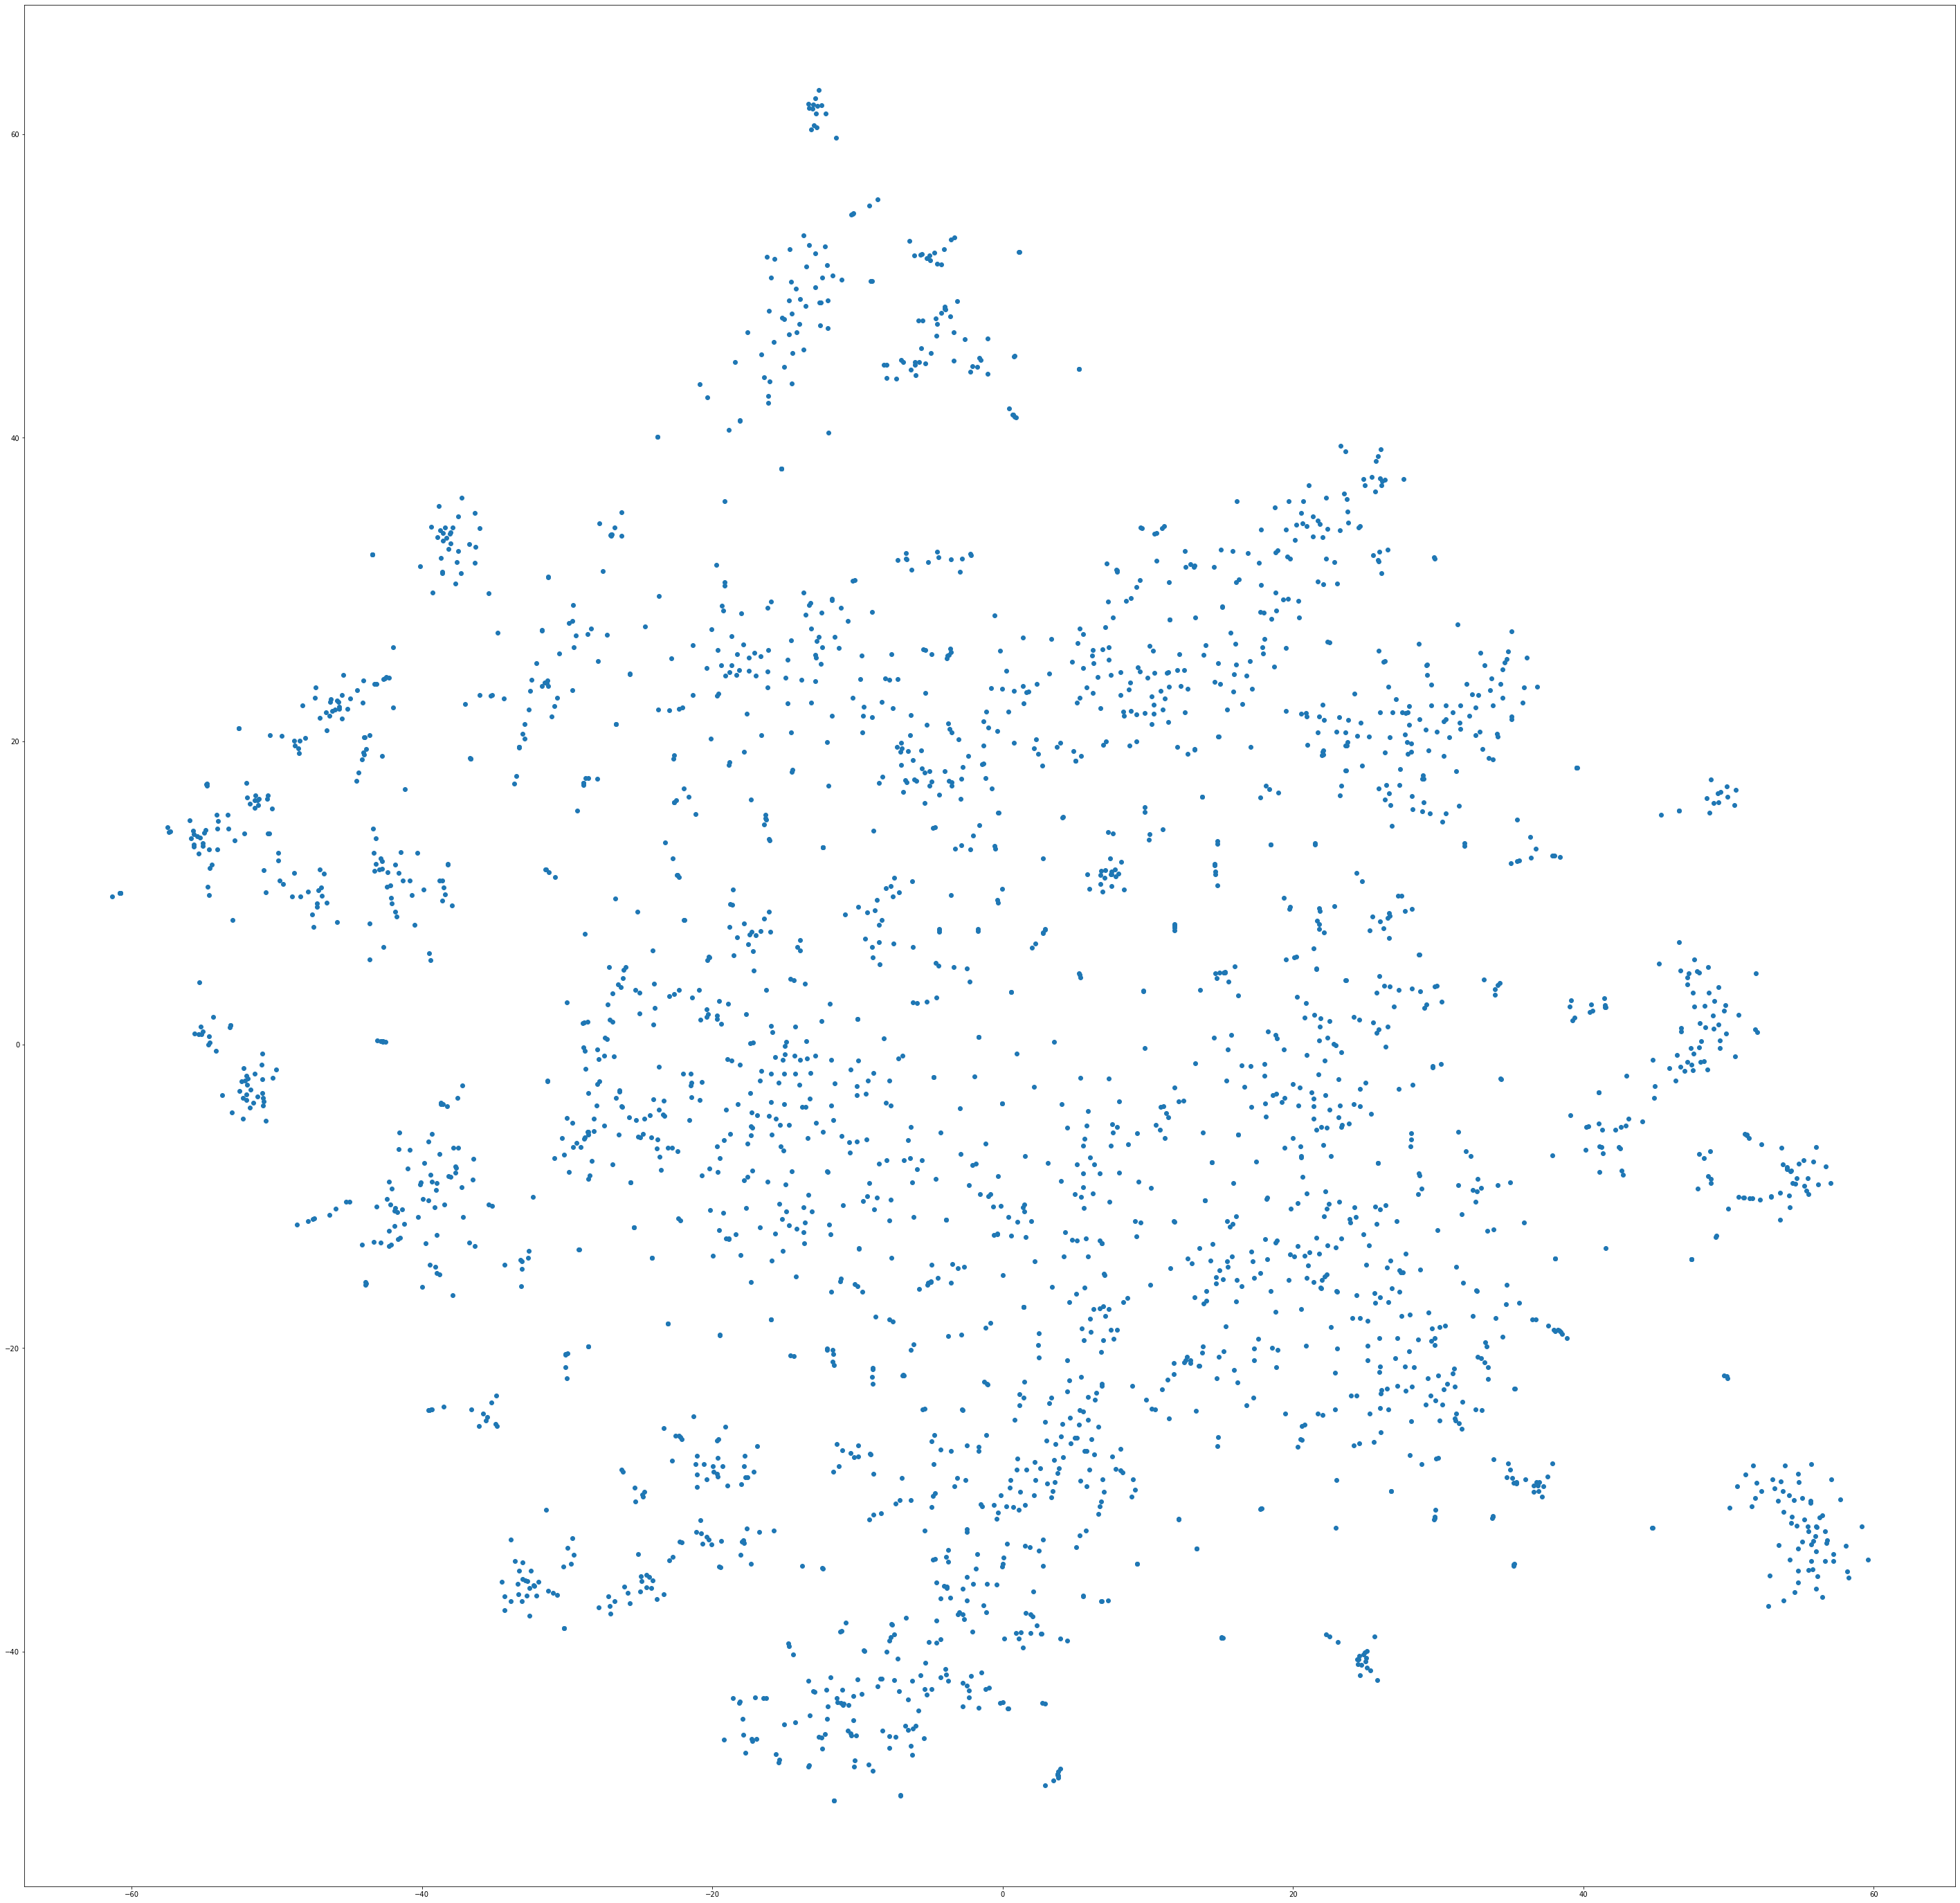

In [7]:
plt.figure(figsize=(50, 50))
plt.scatter(lwi["x"], lwi["y"])

In [8]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Parameters
pixel_length = 1.25 / 400
margin = 1
movement = pixel_length
max_distance =  np.sqrt(2) * pixel_length * 401

def adjust_positions(lwi):
    """Moves overlapping rectangles apart using KDTree and angle-based adjustments"""
    new_lwi = lwi.copy(deep=True)

    # Convert DataFrame to NumPy for speed
    coords = new_lwi[["x", "y"]].values
    widths = (new_lwi["w"] * pixel_length).values
    heights = (new_lwi["h"] * pixel_length).values

    # Build KDTree and find overlapping pairs
    tree = KDTree(coords)
    neighbor_pairs = tree.query_pairs(r=max_distance)  # Only check close neighbors

    changes = np.zeros_like(coords)  # Store movement updates

    count = 0
    for i, j in neighbor_pairs:
        x1, y1 = coords[i]
        x2, y2 = coords[j]
        w1, h1 = widths[i], heights[i]
        w2, h2 = widths[j], heights[j]

        # Calculate the direction vector
        dx, dy = x1 - x2, y1 - y2

        # Calculate angle of overlap using atan2
        angle = np.arctan2(dy, dx)

        # Calculate overlap in X and Y directions
        overlap_x = abs(dx) < (w1 * margin / 2 + w2 * margin / 2)
        overlap_y = abs(dy) < (h1 * margin / 2 + h2 * margin / 2)

        if overlap_x and overlap_y:
            count += 1

            # Calculate movement distance based on overlap
            move_x = movement * np.cos(angle)
            move_y = movement * np.sin(angle)

            # Apply changes in both x and y directions
            changes[i] += [move_x, move_y]
            changes[j] -= [move_x, move_y]

    # Apply updates in batch
    coords += changes
    new_lwi[["x", "y"]] = coords

    return new_lwi, count

# Run until no more overlaps
count = 1
while count > 0:
    new_lwi, count = adjust_positions(lwi)
    lwi = new_lwi  # Update DataFrame
    print(f"Remaining overlaps: {count}")


Remaining overlaps: 4502
Remaining overlaps: 4460
Remaining overlaps: 4438
Remaining overlaps: 4398
Remaining overlaps: 4360
Remaining overlaps: 4314
Remaining overlaps: 4289
Remaining overlaps: 4240
Remaining overlaps: 4205
Remaining overlaps: 4158
Remaining overlaps: 4113
Remaining overlaps: 4077
Remaining overlaps: 4049
Remaining overlaps: 4008
Remaining overlaps: 3969
Remaining overlaps: 3926
Remaining overlaps: 3909
Remaining overlaps: 3862
Remaining overlaps: 3852
Remaining overlaps: 3808
Remaining overlaps: 3788
Remaining overlaps: 3754
Remaining overlaps: 3732
Remaining overlaps: 3715
Remaining overlaps: 3678
Remaining overlaps: 3666
Remaining overlaps: 3632
Remaining overlaps: 3624
Remaining overlaps: 3589
Remaining overlaps: 3564
Remaining overlaps: 3553
Remaining overlaps: 3533
Remaining overlaps: 3498
Remaining overlaps: 3481
Remaining overlaps: 3464
Remaining overlaps: 3472
Remaining overlaps: 3431
Remaining overlaps: 3437
Remaining overlaps: 3373
Remaining overlaps: 3397


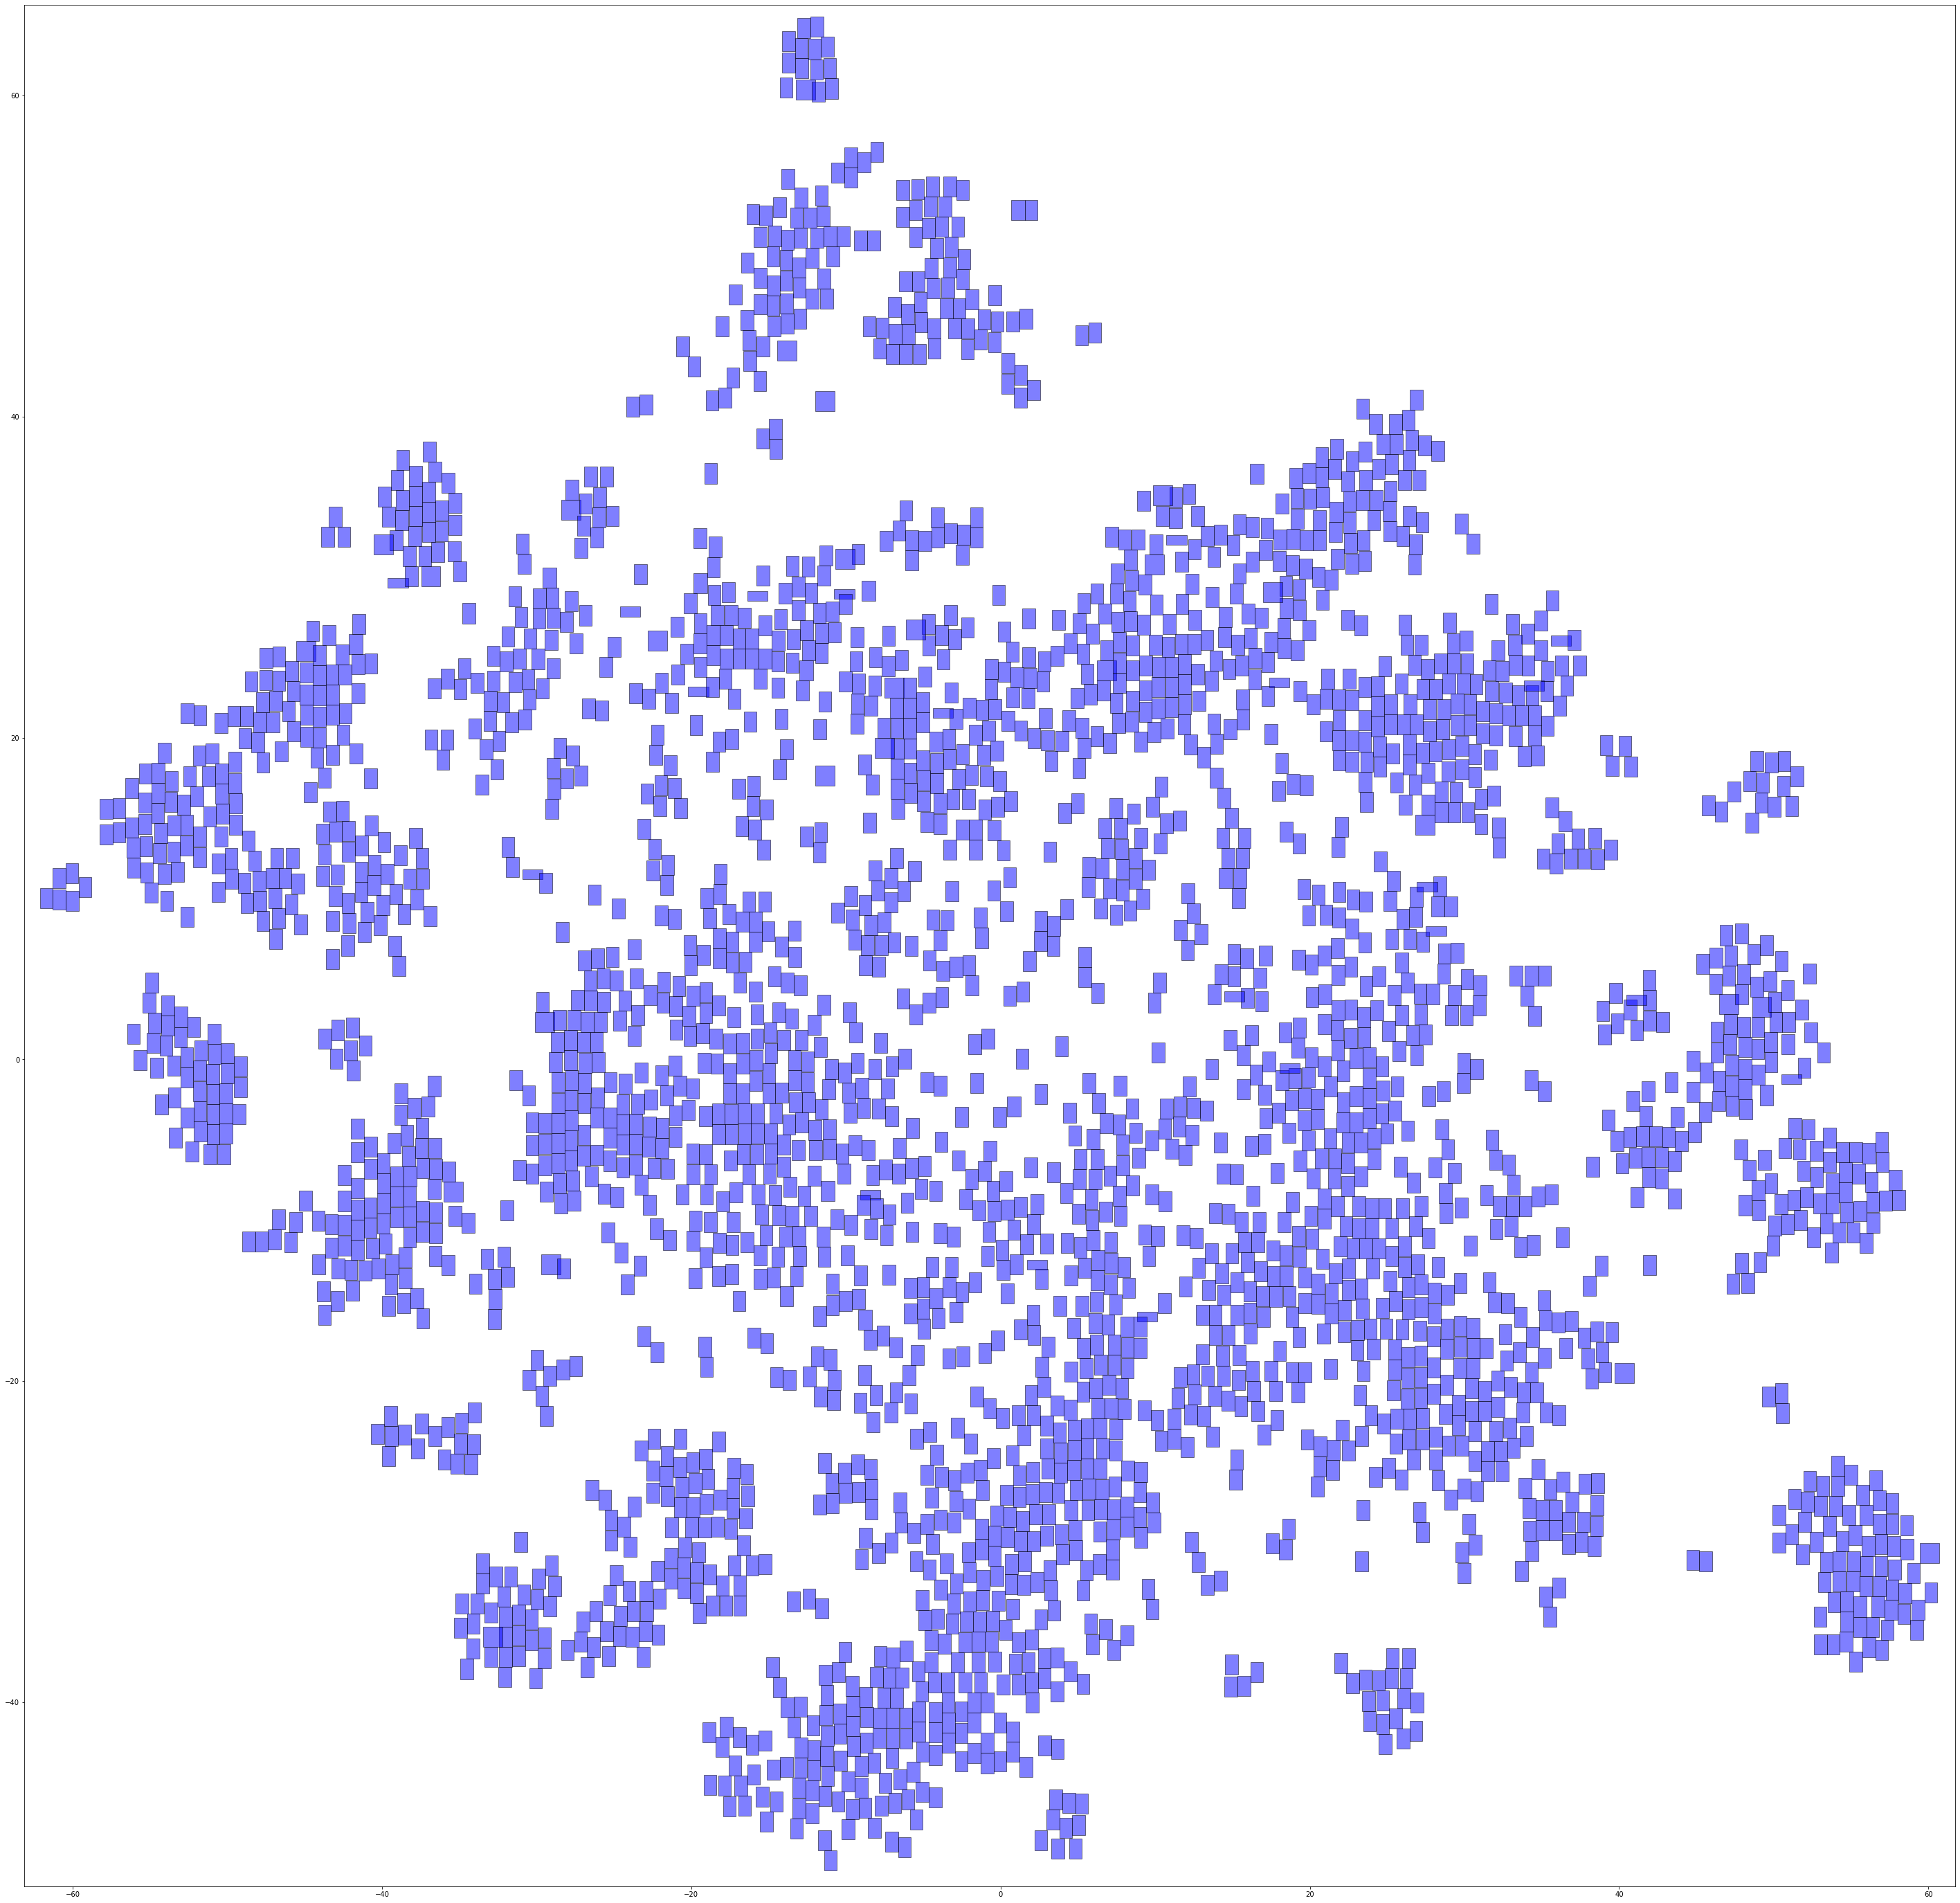

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# Create a list of rectangle patches at each (x, y)
patches = [mpatches.Rectangle((x, y), pixel_length * w, pixel_length * h) for x, y, w, h in zip(lwi["x"], lwi["y"], lwi["w"], lwi["h"])]

fig, ax = plt.subplots(figsize=(50, 50))  # Adjust figure size as needed
collection = PatchCollection(patches, facecolor='blue', edgecolor='black', alpha=0.5)
ax.add_collection(collection)

# Set the limits to ensure all patches are visible
ax.set_xlim(min(lwi["x"]) - 1, max(lwi["x"]) + 2)
ax.set_ylim(min(lwi["y"]) - 1, max(lwi["y"]) + 2)
plt.show()



In [10]:
lwi.to_csv("site/data/final_locations.csv")